In [8]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils.data.sampler import RandomSampler
import cv2
from matplotlib import pyplot as plt
from imp import reload
from utils import util
reload(util)

<module 'utils.util' from '/Users/wanjun/Desktop/比赛训练营/Kaggle化学式识别/server_code/src/utils/util.py'>

In [9]:
# 生成 kfold 训练集
util.make_train(fold=6)
# 生成测试集
util.make_test()

len(tokenizer) : vocab_size 193


apply: 100%|██████████| 2424186/2424186 [00:02<00:00, 837819.14it/s] 


In [13]:
# 获取 fold 0 的数据
# 可以使用 kfold 模型融合技巧
fold = 0
df_labels = pd.read_csv('../data/bms-molecular-translation/df_train.csv')
# 获取训练集
df_train = df_labels[df_labels.fold!=fold]
# 获取验证集
df_valid = df_labels[df_labels.fold==fold]
# 利用 eval 将 str -> list
df_train['sequence'] = df_train.sequence.progress_apply(lambda x:eval(x))
df_valid['sequence'] = df_valid.sequence.progress_apply(lambda x:eval(x))
# 获取需要的列
df_train = df_train[['image_id','InChI','formula','text','sequence','length']]
df_valid = df_valid[['image_id','InChI','formula','text','sequence','length']]

apply: 100%|██████████| 2020155/2020155 [01:19<00:00, 25528.73it/s]
/home/meirtz/anaconda3/envs/vision/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
apply: 100%|██████████| 404031/404031 [00:15<00:00, 26449.33it/s]
/home/meirtz/anaconda3/envs/vision/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [25]:
# 测试集做上面相同的处理
df_test = pd.read_csv('../data/bms-molecular-translation/df_test.csv')
df_test['sequence'] = df_test.sequence.progress_apply(lambda x:eval(x))
df_test = df_test[['image_id','InChI','formula','text','sequence','length','orientation']]
# 保存为 pkl 文件
df_train.to_pickle('../data/df_train0.pkl')
df_valid.to_pickle('../data/df_valid0.pkl')
df_test.to_pickle('../data/df_test.pkl')

In [26]:
# 加载分词器
token = util.load_tokenizer()
# 生成 torch 的 Dataset
dataset_train = util.BmsDataset(df_train, token)
# 验证第 0 个的输出
print(dataset_train[0])
print('########################')
print(dataset_train[0].keys())
print('########################')
len(dataset_train[0]['d']['text'].split(' '))+2 == len(dataset_train[0]['token'])

len(tokenizer) : vocab_size 193
{'index': 0, 'image_id': '000011a64c74', 'InChI': 'InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12(13)11(4)14/h5-7,9,11,14H,8H2,1-4H3', 'formula': 'C13H20OS', 'd': image_id                                         000011a64c74
InChI       InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...
formula                                              C13H20OS
text        C 13 H 20 O S /c 1 - 9 ( 2 ) 8 - 15 - 13 - 6 -...
sequence    [190, 178, 47, 182, 89, 185, 187, 6, 13, 4, 16...
length                                                     38
Name: 0, dtype: object, 'image': array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8), 'token': [190, 178, 47, 182, 89, 185, 187, 6, 13, 4, 165, 0, 88, 1, 154, 4, 69, 4, 47, 4, 132, 4, 121, 4, 14,

True

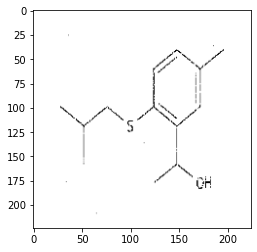

In [27]:
plt.imshow(dataset_train[0]['image'],cmap='gray')

In [35]:
# 检查训练集的 loader 和 collate_fn
loader = DataLoader(
        dataset_train,
        sampler = RandomSampler(dataset_train), # 抽样方法
        batch_size  = 8,
        drop_last   = True,
        num_workers = 0,
        pin_memory  = True, # 锁页内存
        collate_fn  = util.collate_fn, # 整理函数
    )
for t,batch in enumerate(loader):
    if t>2: break

    print(t, '-----------')
    print('index : ', batch['index'])
    print('image : ')
    print('\t', batch['image'].shape, batch['image'].is_contiguous())
    print('length  : ')
    print('\t',len( batch['length']))
    print('\t', batch['length'])
    print('token  : ')
    print('\t', batch['token'].shape, batch['token'].is_contiguous())
    print('\t', batch['token'])

    print('')

0 -----------
index :  [1519542, 94064, 905535, 826743, 430770, 1420259, 1033139, 135811]
image : 
	 torch.Size([8, 3, 224, 224]) True
length  : 
	 8
	 [111, 108, 93, 71, 62, 57, 52, 48]
token  : 
	 torch.Size([8, 300]) True
	 tensor([[190, 178,  98,  ..., 192, 192, 192],
        [190, 178, 105,  ..., 192, 192, 192],
        [190, 178,  97,  ..., 192, 192, 192],
        ...,
        [190, 178,  86,  ..., 192, 192, 192],
        [190, 178,  58,  ..., 192, 192, 192],
        [190, 178,  25,  ..., 192, 192, 192]])

1 -----------
index :  [341701, 20290, 499049, 1242740, 1313691, 645673, 1883744, 19527]
image : 
	 torch.Size([8, 3, 224, 224]) True
length  : 
	 8
	 [89, 61, 57, 52, 52, 50, 44, 37]
token  : 
	 torch.Size([8, 300]) True
	 tensor([[190, 178,  94,  ..., 192, 192, 192],
        [190, 178,  87,  ..., 192, 192, 192],
        [190, 178,  47,  ..., 192, 192, 192],
        ...,
        [190, 178,  47,  ..., 192, 192, 192],
        [190, 178,  36,  ..., 192, 192, 192],
        [190, 1

In [33]:
token = util.load_tokenizer()
dataset_test = util.BmsDataset(df_test, token, mode = 'test', augment = util.rot_augment)
print(dataset_test[0])
print('########################')
print(dataset_test[0].keys())
print('########################')

len(tokenizer) : vocab_size 193
{'index': 0, 'image_id': '00000d2a601c', 'InChI': 0, 'formula': 0, 'd': Unnamed: 0                0
image_id       00000d2a601c
InChI                     0
orientation               0
path                   test
formula                   0
text                      0
sequence                [0]
length                    1
Name: 0, dtype: object, 'image': array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8), 'token': [0]}
########################
dict_keys(['index', 'image_id', 'InChI', 'formula', 'd', 'image', 'token'])
########################


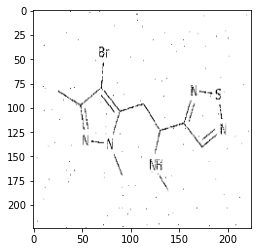

In [34]:
plt.imshow(dataset_test[0]['image'],cmap='gray')

In [37]:
# 检查测试集的 loader 和 collate_fn
loader = DataLoader(
        dataset_test,
        sampler = RandomSampler(dataset_test),
        batch_size  = 8,
        drop_last   = True,
        num_workers = 0,
        pin_memory  = True,
        collate_fn  = lambda batch: util.collate_fn(batch,False),
    )
for t,batch in enumerate(loader):
    if t>2: break

    print(t, '-----------')
    print('index : ', batch['index'])
    print('image : ')
    print('\t', batch['image'].shape, batch['image'].is_contiguous())
    print('length  : ')
    print('\t',len( batch['length']))
    print('\t', batch['length'])
    print('token  : ')
    print('\t', batch['token'].shape, batch['token'].is_contiguous())
    print('\t', batch['token'])

    print('')

0 -----------
index :  [141612, 1320846, 670164, 255871, 992161, 1452574, 1346787, 138620]
image : 
	 torch.Size([8, 3, 224, 224]) True
length  : 
	 8
	 [1, 1, 1, 1, 1, 1, 1, 1]
token  : 
	 torch.Size([8, 300]) True
	 tensor([[  0, 192, 192,  ..., 192, 192, 192],
        [  0, 192, 192,  ..., 192, 192, 192],
        [  0, 192, 192,  ..., 192, 192, 192],
        ...,
        [  0, 192, 192,  ..., 192, 192, 192],
        [  0, 192, 192,  ..., 192, 192, 192],
        [  0, 192, 192,  ..., 192, 192, 192]])

1 -----------
index :  [971827, 1357054, 1289519, 396810, 1540950, 1181771, 581540, 239090]
image : 
	 torch.Size([8, 3, 224, 224]) True
length  : 
	 8
	 [1, 1, 1, 1, 1, 1, 1, 1]
token  : 
	 torch.Size([8, 300]) True
	 tensor([[  0, 192, 192,  ..., 192, 192, 192],
        [  0, 192, 192,  ..., 192, 192, 192],
        [  0, 192, 192,  ..., 192, 192, 192],
        ...,
        [  0, 192, 192,  ..., 192, 192, 192],
        [  0, 192, 192,  ..., 192, 192, 192],
        [  0, 192, 192,  ...,